<a href="https://colab.research.google.com/github/Yongtae723/personal_study_code/blob/main/Europe_soccer_what_country_is_the_most_easyist_predicted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

欧州サッカーで最も勝率予想が偏るリーグを調べた
データは[ここ](https://www.kaggle.com/hugomathien/soccer)からインストール


## kaggleのトークンをインストール

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yongte1993","key":"00e852b5b86fed0ac6c85e25f42dcdd1"}'}

In [ ]:
!mkdir -p ~/.kaggle  #kaggleのファイルを作る
!cp kaggle.json ~/.kaggle  #kaggleのトークンをコピーする

#kaggleのアクセス権を変更する
!chmod 600 ~/.kaggle/kaggle.json

## ここはkaggleのホームページからAPIを導入する

In [ ]:
!kaggle datasets download -d hugomathien/soccer

 44% 15.0M/34.4M [00:00<00:00, 75.3MB/s]
100% 34.4M/34.4M [00:00<00:00, 115MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = 'soccer.zip'

with ZipFile(file_name , 'r') as zip_file:
  zip_file.extractall()
  print('done')

done


## データのロード

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #グラフを綺麗に描写するライブラリ
import pandas as pd
import sqlite3 #軽量・高速なデータベースSQLiteをPythonから扱うためのライブラリ
import numpy as np
from numpy import random

#load data
with sqlite3.connect('./database.sqlite') as con: #SQL言語で扱うSQLiteからpandasのデータフレームに変換
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

In [ ]:
import copy

original_countries = copy.deepcopy(countries)
original_matches = copy.deepcopy(matches)
original_leagues = copy.deepcopy(leagues)
original_teams = copy.deepcopy(teams)

In [ ]:
print(type(countries))
print(type(matches))
print(type(leagues))
print(type(teams))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#select relevant countries and merge with leagues

selected_countries = ['England','France','Germany','Italy','Spain']#top 5 のリーグで解析する

countries = countries[countries.name.isin(selected_countries)]#country nameの中でselected_countriesに含まれる要素をpick upしている

leagues = countries.merge(leagues,on='id',suffixes=('', '_y')) # leagueasにcontriesの名前を追加した

In [ ]:
print(leagues)
print(countries)
print(original_leagues)

      id     name  country_id                  name_y
0   1729  England        1729  England Premier League
1   4769   France        4769          France Ligue 1
2   7809  Germany        7809   Germany 1. Bundesliga
3  10257    Italy       10257           Italy Serie A
4  21518    Spain       21518         Spain LIGA BBVA
      id     name
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy
9  21518    Spain
       id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super

In [ ]:
#select relevant fields

matches = matches[matches.league_id.isin(leagues.id)]#leagueに格納したリーグの試合情報をインプット
#B365Hはホームが勝った時の掛け率　B365Dはドロー　B365Aはアウェー
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]


matches.dropna(inplace=True)

matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33


In [ ]:
from scipy.stats import entropy



def match_entropy(row):#掛け率から予想された勝率を計算→確立のエントロピーを計算

    odds = [row['B365H'],row['B365D'],row['B365A']]

    #change odds to probability

    probs = [1/o for o in odds]#掛け率の逆数を勝率と計算している

    #normalize to sum to 1

    norm = sum(probs)

    probs = [p/norm for p in probs]

    return entropy(probs)



#compute match entropy

matches['entropy'] = matches.apply(match_entropy,axis=1)

In [ ]:
entropy_means = matches.groupby(('season','league_id')).entropy.mean()#season毎、リーグごとにデータを区分

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')
entropy_means.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


league_id,1729,4769,7809,10257,21518
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


In [ ]:
#compute mean entropy for every league in every season

entropy_means = matches.groupby(('season','league_id')).entropy.mean()#season毎、リーグごとにデータを区分

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')#カラムとインデックスを入れかえ

entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]#columnsの名前の入れ替え

entropy_means.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.984556,1.026638,1.004276,1.002201,1.010859
2009/2010,0.956496,1.013821,0.997925,1.006755,0.977810
2010/2011,0.983258,1.026236,1.016264,1.006029,0.975032
2011/2012,0.969593,1.024915,1.001298,1.003077,0.955339
2012/2013,0.981472,1.016116,0.993993,1.003565,0.970580
2013/2014,0.960473,1.004439,0.977500,0.992622,0.944218
2014/2015,0.980301,1.012495,0.985835,0.999100,0.933637
2015/2016,0.997819,1.013928,0.974657,0.985284,0.946813


上で求めたcellをplot

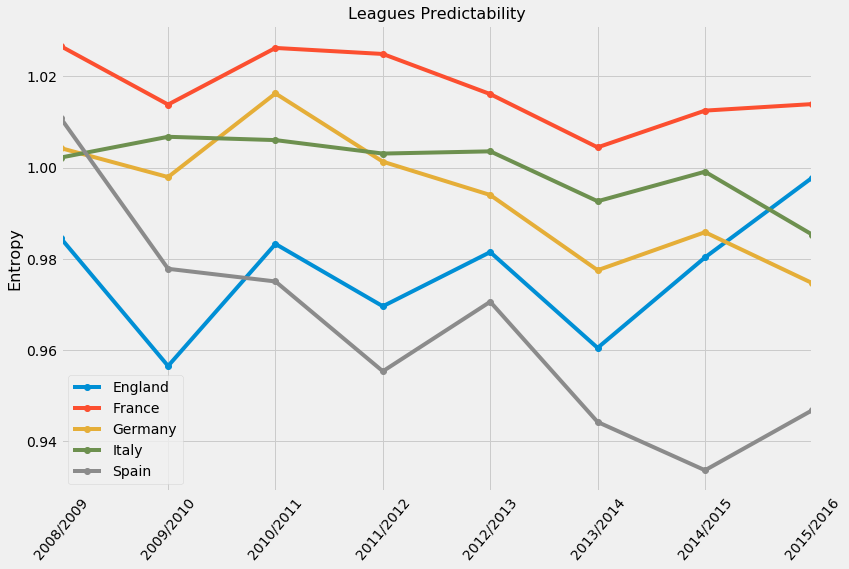

In [ ]:
#plot graph
plt.style.use('fivethirtyeight')
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]#プロットした色の取得
colors_mapping = dict(zip(leagues.id,colors))#辞書にする

#remove x label
ax.set_xlabel('')
#add y label
ax.set_ylabel('Entropy' ,fontsize=16)

#locate legend 
plt.legend(loc='lower left')

plt.savefig('Leagues Predictability.png', bbox_inches='tight', dpi = 64)

各チーム・シーズンごとの勝率のentropy

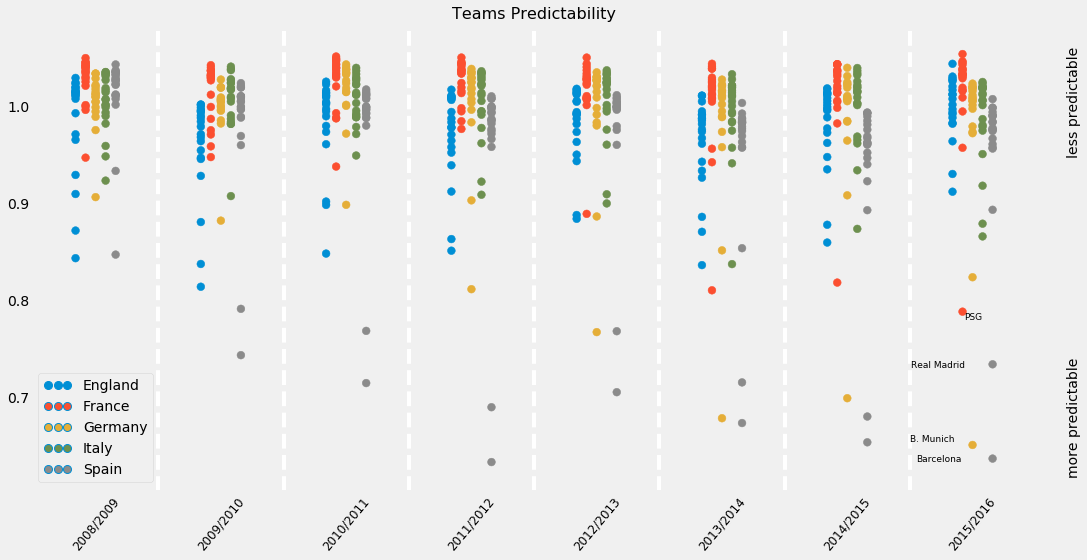

In [ ]:
from matplotlib.lines import Line2D


barcelona = teams[teams.team_long_name=='FC Barcelona'].team_api_id.values[0]# id of barcelona
offsets = [-0.16,-0.08,0,0.08,0.16]#plotでx軸にoffsetだけずらす
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))#国のidとoffset
y = []#entropyが格納される
x = []#plotのxposition
c = []#leagueの色が格納される(plot時の色分けのために)

i = -1
for season,season_df in matches.groupby('season'):#season毎の解析
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):#team = team's id , name = team's name
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]#homeの試合or awayの試合
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:#バグがなければ
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])

plt.figure(figsize=(16,8))
plt.scatter(x,y,color=c,s=[60]*len(x))
plt.title('Teams Predictability', fontsize=16)

#create ticks and labels
ax = plt.gca()
plt.xlim((-0.5,7.5))
plt.xticks(np.arange(0,8,1),rotation=50)

#create grid
ax.set_xticklabels(entropy_means.index,fontsize=12)
for i in range(7):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

#create legend
circles = []
labels = []
for league_id,name in zip(leagues.id,leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))

#add arrows
ax.annotate('', xytext=(7.65, 0.93),xy=(7.65, 1.1),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.65, 0.77),xy=(7.65, 0.6),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.75, 1.05), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.73), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)

plt.savefig('tram Predictability per season', bbox_inches='tight', dpi = 64)

Top5のチームのentropyの遷移

In [ ]:
team_long_names=['FC Barcelona' , 'Paris Saint-Germain' ,'FC Bayern Munich' ,'Real Madrid CF' , 
                 'Liverpool' ]

entropy_teams=pd.DataFrame()

for team_long_name in team_long_names:
  team_id = teams[teams.team_long_name == team_long_name].team_api_id.values[0]
  team_matches=matches[(matches.home_team_api_id == team_id)|(matches.away_team_api_id == team_id)]
  team_entropy_add = pd.DataFrame(team_matches.groupby('season').entropy.mean())
  team_entropy_add = team_entropy_add.rename(columns={'entropy':team_long_name})
  if entropy_teams.empty:
    entropy_teams=team_entropy_add
  else:
    entropy_teams=entropy_teams.join(team_entropy_add)

print(entropy_teams)

           FC Barcelona  Paris Saint-Germain  FC Bayern Munich  \
season                                                           
2008/2009      0.846811             1.020466          0.905928   
2009/2010      0.743383             1.035974          0.881747   
2010/2011      0.714679             1.019818          0.898005   
2011/2012      0.633427             0.976040          0.811240   
2012/2013      0.705304             0.888720          0.767086   
2013/2014      0.673565             0.810100          0.678528   
2014/2015      0.653760             0.818040          0.699118   
2015/2016      0.637001             0.788118          0.651024   

           Real Madrid CF  Liverpool  
season                                
2008/2009        0.932918   0.909148  
2009/2010        0.791028   0.927762  
2010/2011        0.768361   0.996642  
2011/2012        0.689847   0.970277  
2012/2013        0.768021   0.972953  
2013/2014        0.715362   0.885634  
2014/2015        0.680268  

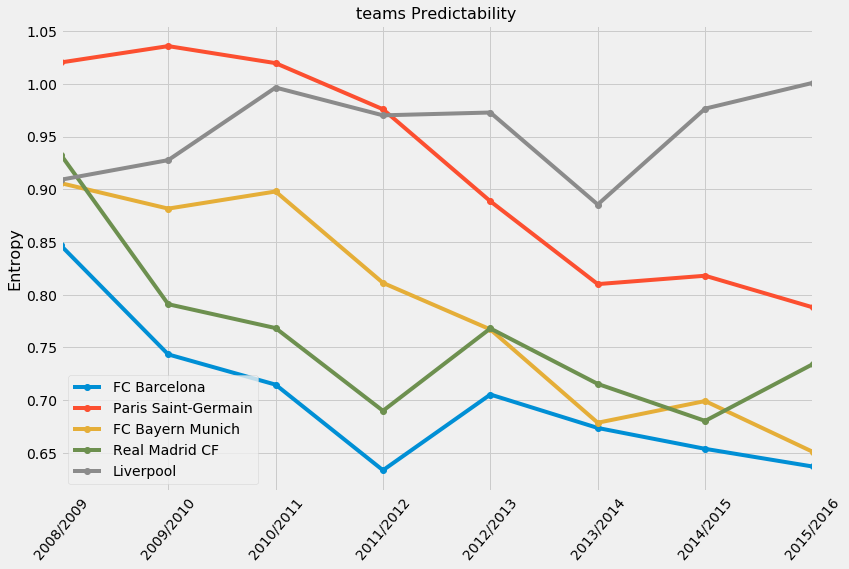

In [ ]:
#plot graph
ax = entropy_teams.plot(figsize=(12,8),marker='o')

#set title
plt.title('teams Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)


#remove x label
ax.set_xlabel('')
#add y label
ax.set_ylabel('Entropy' ,fontsize=16)

#locate legend 
plt.legend(loc='lower left')
plt.savefig('Each team Predictability', bbox_inches='tight', dpi = 64)


#サッカーの試合ではHomeとAwayで得点にどんな影響があるのか(今までとはあんまり関係のない解析)

In [ ]:
with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)


In [ ]:
countries_leagues = countries.merge(leagues,left_on="id",right_on="id",how="outer")
countries_leagues = countries_leagues.drop("id",axis = 1)
countries_leagues = countries_leagues.rename(columns={'name_x':"country", 'name_y':"league"})

#subsetting data with necessary columns
matches_new = matches[['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                   'match_api_id', 'home_team_api_id', 'away_team_api_id',
                    'home_team_goal', 'away_team_goal']]

matches_new = matches_new.drop("id",axis=1)

data = matches_new.merge(countries_leagues,left_on="country_id",right_on="country_id",how="outer")


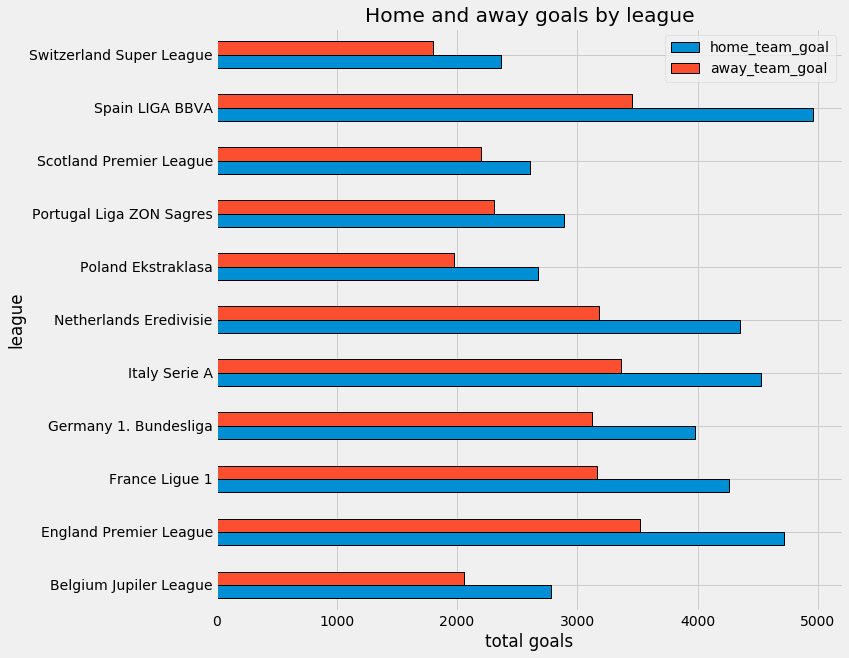

In [ ]:
#HomeとAwayの試合で総得点を計算し表示
data.groupby("league").agg({"home_team_goal":"sum","away_team_goal":"sum"}).plot(kind="barh",
                                                                                 figsize = (10,10),
                                                                                 edgecolor = "k",
                                                                                 linewidth =1
                                                                                )
plt.title("Home and away goals by league")
plt.legend(loc = "best" , prop = {"size" : 14})
plt.xlabel("total goals")
plt.savefig('home and away goal number')

##↑確かにHomeの試合の方が得点している

Spain leagueの得点が多いことが気になった
試合数が多いだけ？やっぱり世界最高リーグのスペインリーグは点の取り合いの試合なの？

という疑問を調べた

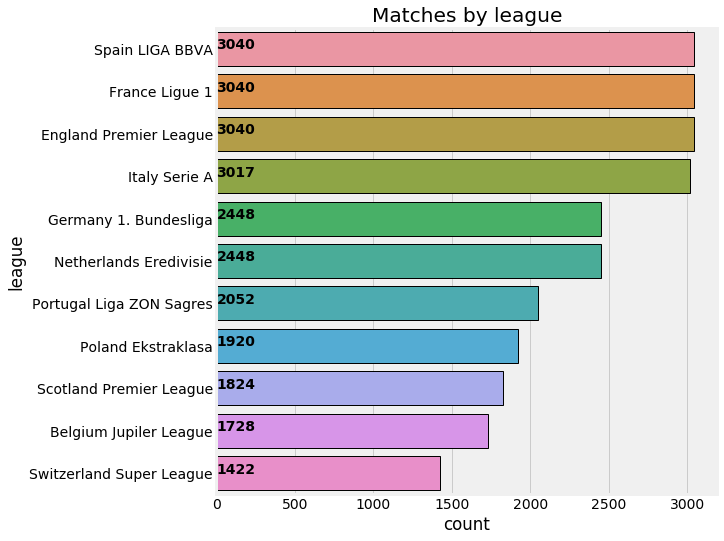

In [ ]:
plt.figure(figsize=(8,8) , facecolor = 'white')
ax = sns.countplot(y = data["league"],
                   order=data["league"].value_counts().index,
                   linewidth = 1,
                   edgecolor = "k"*data["league"].nunique()
                 )
for i,j in enumerate(data["league"].value_counts().values):
    ax.text(.7,i,j,weight = "bold")
plt.title("Matches by league")

plt.savefig('number of matchs')

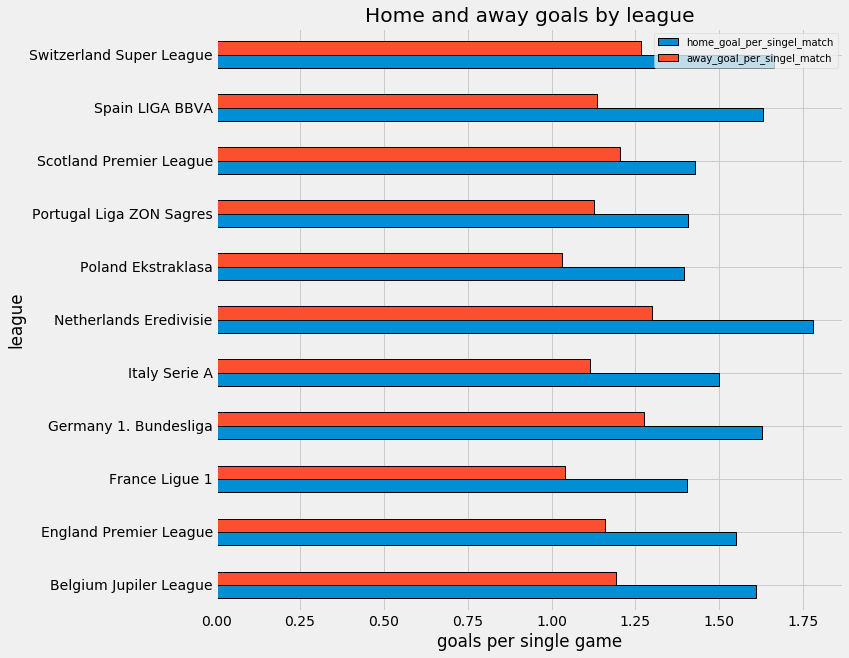

In [ ]:
#１試合当たりの特典をしたべた
goal_num_df=data.groupby("league").agg({"home_team_goal":"sum","away_team_goal":"sum"})
match_num_df=pd.DataFrame(data["league"].value_counts()).rename(columns={"league" : "match_num"})
goal_num_df=goal_num_df.join(match_num_df)
goal_num_df['home_goal_per_singel_match'] = goal_num_df['home_team_goal']/goal_num_df['match_num']
goal_num_df['away_goal_per_singel_match'] = goal_num_df['away_team_goal']/goal_num_df['match_num']


#goal_num_df['home_goal_per_singel_match']
goal_num_df.plot.barh(y=['home_goal_per_singel_match' ,'away_goal_per_singel_match' ],
                     figsize = (10,10),
                     edgecolor = "k",
                     linewidth =1
                    )

plt.title("Home and away goals by league")
plt.legend(loc = "best" , prop = {"size" : 10})
plt.xlabel("goals per single game")


plt.savefig('home and away goal number per single game')

結論：スペインリーグは試合数が多いだけだった